# Tutorial: Fitting a DA Spectrum

For this demonstration, we use a sample spectrum from the Sloan Digital Sky Survey (SDSS) named SDSS J082600.58+282346.2. 

Tremblay et al. (2019) assigned this star an effective temperature of $13917$ Kelvin and a surface gravity of $8.06$ log[cm/s^2] using their latest atmospheric models and this SDSS spectrum. In this notebook we'll demonstrate how you can use `wdtools` to infer these parameters from any white dwarf spectrum. 

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

speed_light = 299792458 #m/s



import sys
sys.path.append('../../') # Your path should contain the parent GitHub repository

import wdtools

In [2]:
with fits.open('sample_spectrum.fits') as f:
    flux = f[1].data['flux']
    wl = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

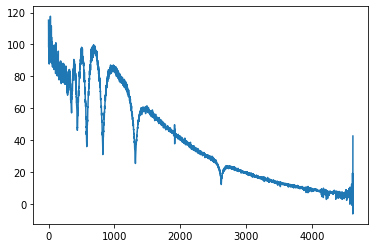

In [3]:
plt.plot(flux)

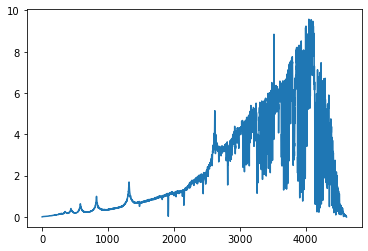

In [4]:
plt.plot(ivar)

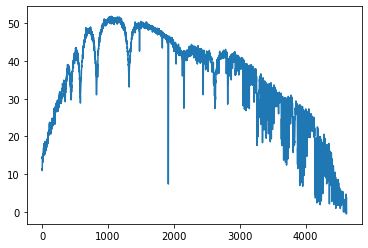

In [5]:
plt.plot(flux * np.sqrt(ivar))

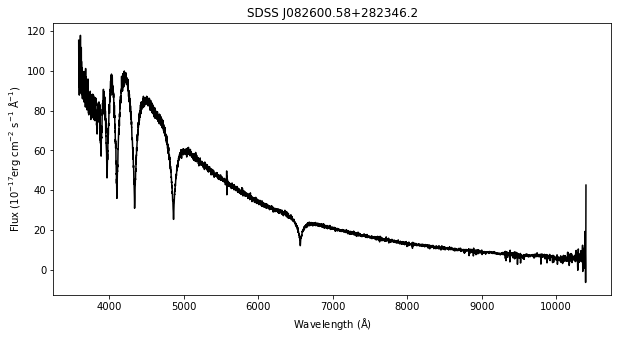

In [6]:
plt.figure(figsize = (10,5))
plt.plot(wl, flux, 'k')
plt.xlabel('Wavelength ($\mathrm{\AA}$)');
plt.ylabel('Flux ($\mathrm{10^{-17} erg\ cm^{-2}\ s^{-1}\ \AA^{-1}}$)')
plt.title('SDSS J082600.58+282346.2');

## Generative Fitting Pipeline

We normalize the hydrogen Balmer lines and fit atmospheric models from Koester (2010) to this spectrum using our MCMC algorithm.

In [7]:
gfp = wdtools.GFP(resolution = 2, specclass = 'DA')

We pass the instrumental resolution in Angstroms when we initialize `GFP`. The theoretical models are convolved with a Gaussian kernel with this resolution prior to each fitting step. We also select the `'DA'` spectral class to fit pure-hydrogen models. At this time, these are the only models available. In future we hope to include helium (DB) models when those models become publicly available. 

You can use the `sfac` keyword to tweak the smoothing of the spline continuum fit. `sfac=1` corresponds to a default rule-of-thumb value that works in most cases, but you can vary this fraction to get a perfect continuum fit. If fitting a large set of stars, you can experiment to find a value that works for the sample and then fix it. 

fitting radial velocity...
fitting continuum...


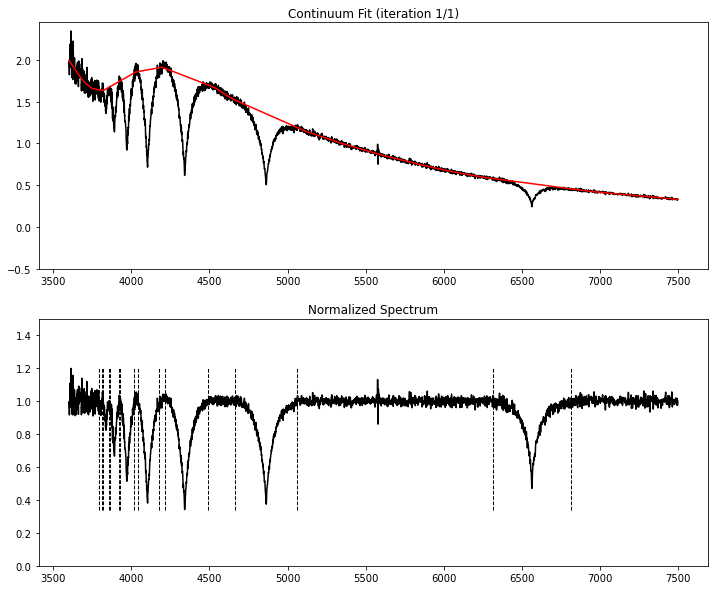

Radial Velocity = 21 ± 16 km/s
final optimization...
initializing at teff = 8000 K
initializing at teff = 21500 K
initializing at teff = 35000 K
[13731.34215763991, 8.159632618191637]
[61.64263978440498, 0.012985238113274214]
burning in chains...


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


sampling posterior...


100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


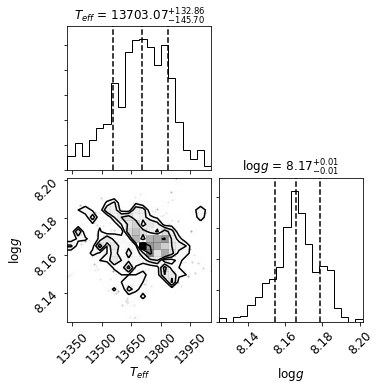

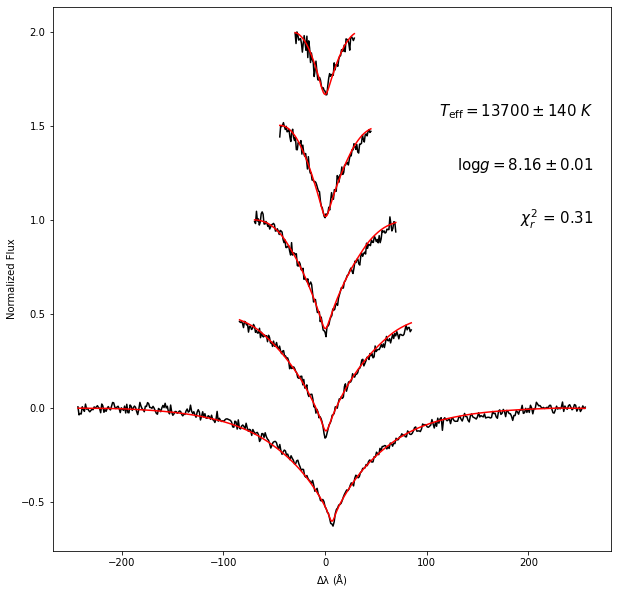

In [8]:
labels, e_labels, redchi = gfp.fit_spectrum(wl, flux, ivar,
                                mcmc = True, nwalkers = 25, burn = 50, ndraws = 50,
                                plot_init = True, make_plot = True, plot_corner = True, savename = 'example',
                                verbose = True,
                                lines = ['beta', 'gamma', 'delta', 'eps', 'h8'])

In [9]:
print('Teff = %i ± %i Kelvin' % (labels[0], e_labels[0]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (labels[1], e_labels[1]))
print('RV = %.1f ± %.1f km/s' % (labels[2], e_labels[2]))
print('reduced chi^2 = %.2f' % (redchi))

Teff = 13700 ± 139 Kelvin
logg = 8.16 ± 0.01 log[cm/s^2]
RV = 21.2 ± 16.3 km/s
reduced chi^2 = 0.31


All parameters passed to `gfp.fit_spectrum` other than the normalized wavelength, flux, and inverse variance array are optional.

We initialize the sampling at a high-probability region of parameter space by finding parameters that minimize the $\chi^2$ using a Nelder-Mead solver. We fit once with a 'cold' prior (T < 15000 K), and once with a 'hot' prior (T > 15000 K), and select the one with the lowest $\chi^2$ as the initialization point. 

The MCMC hyperparameter selection involves a trade-off between accuracy and speed. Unless you have a particular need for more samples or quicker sampling, you can leave them at the default settings, which should enable you to fit a single spectrum in under a minute on a regular laptop computer. We recommend keeping `burn` greater than 100 steps at least, so that walkers can spread out from the high-probability starting point and explore the likelehood. Otherwise, the errors on fitted parameters can be grossly underestimated. You can also pass the `mcmc = False` keyword to `fit_spectrum` to skip the MCMC sampling and simply return the optimized solution.

## Fitting RVs using a Single Absorption Line

You can use a single absorption line to find the RV of a star, assuming you know the rest frame wavelength of that absorption line. This function first fits the absorption line with a sum of concentric Voigt profiles (the number is governed by `nmodel`) to obtain a model-independent template profile. It then fixes that composite profile as a template and performs a cross-correlation to determine the RV. The cross-correlation is repeated for 100 realizations of the observed spectrum (using the provided `ivar` array) to propagate RV uncertainties. The mean and standard deviation of the RV realizations is reported by the function. 

The `distance` keyword governs how far away from `centroid` (in Angstroms) we consider in the fit. The `edge` keyword governs how many pixels on each side of the line are used to define a simple linear continuum before the fitting procedure. By tweaking these parameters, this function can be used to fit any absorption line. To fit an emission line, simply take the negative of the flux before running the function. 

We demonstrate here with H-alpha:

In [12]:
sp = wdtools.SpecTools()
h_alpha = 6564.61

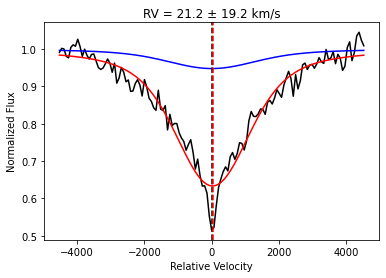

In [15]:
rv, e_rv = sp.get_line_rv(wl, flux, ivar, centroid = h_alpha, 
                          distance = 100, edge = 15, 
                          nmodel = 2, plot = True)

## Parametric Random Forest

Rather than fitting ab-inito models directly to observed spectra, the parametric random forest in `wdtools` forms a regression relation between the hydrogen Balmer lines on the spectrum and stellar labels derived by previous studies. Whilst this method is less interpretable than the full statistical approach described above, it is much faster and therefore suitable for statistical analyses on larger samples. Additionally, fitting an ab-initio model directly requires some care regarding multi-modal posteriors, photometric temperature priors, and so on. 

We train our model with a pre-existing catalog of stars that have been carefully fitted for their stellar labels (keeping all the confounding effects in mind) by Tremblay et al. (2019). For more details, refer to our paper or software documentation.

In [16]:
lp = wdtools.LineProfiles(lines = ['alpha', 'beta', 'gamma', 'delta'])

The trianing SDSS data only permitted high-quality line profile fits to the first 4 Balmer lines, so you can only pass some subset of those for this method. The first time you call `LineProfiles` on your machine, it will perform a self-initialization to train its regression model for the provided combination of lines and save it in the `models/` folder. This should only take a few seconds and will create a ~60 MB pickled random forest model that will be used every time you subsequently call `LineProfiles`. 

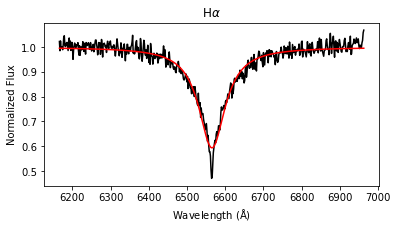

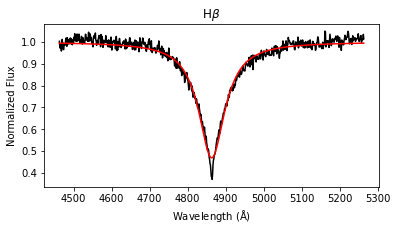

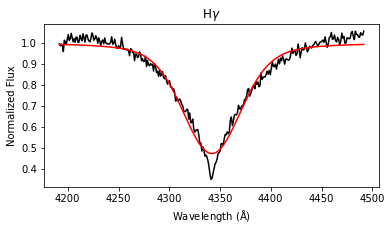

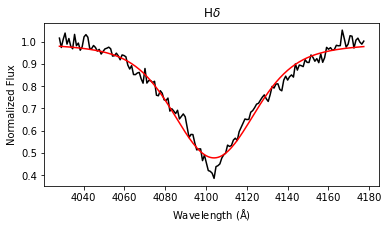

In [17]:
results = lp.labels_from_spectrum(wl, flux, make_plot = True)

In [18]:
print('Teff = %i ± %i Kelvin' % (results[0], results[1]))
print('logg = %.2f ± %.2f log[cm/s^2]' % (results[2], results[3]))

Teff = 13912 ± 295 Kelvin
logg = 8.10 ± 0.06 log[cm/s^2]


The `labels_from_spectrum` method fits all selected Balmer lines with a Voigt profile to compute their FWHM and height, and then runs the fitted parameters through the ensemble of random forest regression models to produce stellar label estimates with uncertainties. 

Both our methods produce self-consistent stellar labels that are also consistent with the prior result from Tremblay et al. (2019).

For any more details, questions, or comments please don't hesistate to contact the authors via email. You can also [raise an issue](https://github.com/vedantchandra/wdtools/issues) on GitHub for specific software bugs or feature requests. We hope you enjoy using wdtools!